# Cantilever beam physics-informed neural network (PINN)

## Problem overview

The example problem we solve here is a continuous beam:
$$ \rho A \frac{\partial^2w}{\partial t^2} + E I \frac{\partial^4w}{\partial x^4} + \rho A c \frac{\partial w}{\partial t} = f(t) $$
$$ w(x, t) = \sum_{j=1}^{\infty}\varphi_j(x)q_j(t) \approx \sum_{j=1}^{n}\varphi_j(x)q_j(t) $$
where $\varphi_j$ and $q_j$ are the $j^{th}$ modal shape and coordinate of the $j^{th}$ mode, respectively.
$$
\mathbf{M}\ddot{\mathbf{q}}(t) + \mathbf{C}\dot{\mathbf{q}}(t) + \mathbf{K}\mathbf{q}(t) = \mathbf{S_p}\mathbf{p}(t)
$$
where,
$$
\mathbf{M} = \rho A \int_0^l\mathbf{\psi}(x)\mathbf{\psi}^T(x) dx, \qquad
\mathbf{C} = \rho Ac \int_0^l\mathbf{\psi}(x)\mathbf{\psi}^T(x) dx, \qquad
\mathbf{K} = EI \int_0^l\mathbf{\psi}(x){\mathbf{\psi}''''}^T(x) dx
$$
in the state space,
$$
\dot{\mathbf{\tau}}(t) = \mathbf{A} \mathbf{\tau}(t) + \mathbf{H} \mathbf{f}(t)
$$
where,
$$
\mathbf{\tau} = \begin{bmatrix} \mathbf{q}(t) \\ \dot{\mathbf{q}}(t) \end{bmatrix}, \qquad
\mathbf{A} = \begin{bmatrix} 0 & \mathbf{I} \\ -\mathbf{M}^{-1}\mathbf{K} & -\mathbf{M}^{-1}\mathbf{C} \end{bmatrix}, \qquad
\mathbf{H} = \begin{bmatrix} 0 \\ \mathbf{M}^{-1} \end{bmatrix}, \qquad
\mathbf{f}(t) = m_e g\mathbf{\Psi}(x_e)\mathbf{I}
$$
And the measurement vector is,
$$ \mathbf{y}(t) = \begin{bmatrix} S_d & 0 \\ 0 & S_a \end{bmatrix} \begin{bmatrix} \mathbf{q}(t) \\ \ddot{\mathbf{q}}(t) \end{bmatrix} $$

<!-- $$
\mathrm{argmin}\mathcal{L}(\mathbf{x},t;\mathbf{\theta}) := \mathcal{L}_a + \lambda\left[ \mathcal{L}_{ode} \right]
$$
$$
\mathcal{L}_a = \langle \varphi_{kj}\hat{q}_j - y_k^* \rangle
$$
$$
\mathcal{L}_{ode,j} = \langle \hat{\ddot{q}}_j + 2\hat{\zeta}\hat{\omega}_j\hat{\dot{q}}_j + \hat{\omega}^2\hat{q}_j - p^*_j \rangle, \qquad
\mathcal{L}_{ode,j} = \langle \hat{m} \partial^2_{\hat{t}}\mathcal{N}_{\hat{q}} + \hat{c} \partial_{\hat{t}}\mathcal{N}_{\hat{x}} + \hat{k}\mathcal{N}_{\hat{x}} \rangle _{\Omega_d}
$$
where,
$$ \mathcal{N}_{\bullet} = \mathcal{N}_{\bullet}(\mathbf{x};\mathbf{\theta}), \qquad 
\partial_{*}\bullet = \frac{\partial\bullet}{\partial *}, \qquad 
\partial^2_{*}\bullet = \frac{\partial^2\bullet}{\partial *^2}, \qquad
\langle\bullet\rangle _{\Omega_{\kappa}} = \frac{1}{N_{\kappa}}\sum_{x\in\Omega_{\kappa}}\left|\left|\bullet\right|\right|^2 $$

ODE loss function comes from including the normalisation of the parameters, then choosing the suitable range to aid optimisation.

$$
\frac{1}{\alpha_t^2} \partial^2_{\hat{t}}\hat{q} + \tilde{c}\frac{1}{\alpha_t}\partial_{\hat{t}}\hat{q} + \tilde{k} \hat{q} = 0, \qquad \hat{m} \partial^2_{\hat{t}}\hat{q} + \hat{c} \partial_{\hat{t}}\hat{q} + \hat{k}\hat{q} = 0
$$
> trad(itional)
$$
\hat{m} = \frac{1}{\alpha_t^2}, \quad \hat{c} = \tilde{c}\frac{1}{\alpha_t}, \quad \hat{k} = \tilde{k}
$$
> up_time
$$
\hat{m} = \frac{1}{\alpha_t}, \quad \hat{c} = \tilde{c}, \quad \hat{k} = \tilde{k}\alpha_t
$$
> up_time2
$$
\hat{m} = 1, \quad \hat{c} = \tilde{c}\alpha_t, \quad \hat{k} = \tilde{k}\alpha_t^2
$$ -->

In [8]:
from cont_pinn import bbnn, beam_bb_par, beam_bb_seq, normalise
from beam_solutions import cont_beam
from math import pi

import numpy as np
import torch
import torch.nn as nn
device = torch.device("mps")

from tqdm import tqdm
from tqdm.auto import tqdm as tqdma

import matplotlib.pyplot as plt
from matplotlib import cm
from IPython import display
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate training data

In [2]:
def gen_beam_params(E, rho, EI, pA):
    I_ = EI/E
    A_ = pA/rho
    h = (2*I_/A_)**(0.5)
    b = A_/h
    I = (1/12) * b * h**3
    A = b * h
    return I, A, b, h

def plot_vib_surface(ax, x, time, w, sub_samp=10):
    if len(x.shape) == 1 and len(time.shape) == 1:
        xx, tt = torch.meshgrid(x[::sub_samp], time[::sub_samp], indexing="ij")
        x_ = unroll_mat(xx)
        time_ = unroll_mat(tt)
    else:
        if x.shape[1] > 1 and time.shape[1] > 1:
            x_ = unroll_mat(x[::sub_samp,:][:,::sub_samp])
            time_ = unroll_mat(time[::sub_samp,:][:,::sub_samp])
        elif x.shape[1] <= 1 and time.shape[1] <= 1:
            xx, tt = torch.meshgrid(x[::sub_samp], time[::sub_samp], indexing="ij")
            x_ = unroll_mat(xx)
            time_ = unroll_mat(tt)
    if len(w.shape) == 1:
        w_ = w[::sub_samp]
    else:
        if w.shape[1] > 1:
            w_ = unroll_mat(w[::sub_samp,:][:,::sub_samp])
        else:
            w_ = w[::sub_samp]

    ax.plot_trisurf(x_, time_, w_, cmap=cm.plasma, linewidth=0.1, edgecolor='black')
    ax.set_xlabel('x, m')
    ax.set_ylabel('Time, s')
    ax.set_zlabel('w, m')

def plot_vib_scatter(ax, x, time, w, color='grey'):
    ax.scatter3D(x, time, w, color=color)
    ax.set_xlabel('x, m')
    ax.set_ylabel('Time, s')
    ax.set_zlabel('w, m')

def unroll_mat(data):
    nn = data.shape[0]*data.shape[1]
    data_ = torch.zeros(nn)
    di = 0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data_[di] = data[i,j]
            di += 1
    return data_

def roll_mat(data, n1, n2):
    data_ = torch.zeros((n1, n2))
    d_count = 0
    for i in range(n1):
        for j in range(n2):
            data_[i, j] = data[d_count]
            d_count += 1
    return data_

def gen_NN_data(x, t, w, phi=None):
    nd = x.shape[0] * t.shape[0]
    dc = 0
    x_vec, t_vec, w_vec = np.zeros((nd,1)), np.zeros((nd,1)), np.zeros((nd,1))
    if phi != None:
        phi_vec = np.zeros((nd, phi.shape[1]))
    for i in range(x.shape[0]):
        for j in range(t.shape[0]):
            x_vec[dc] = x[i]
            t_vec[dc] = t[j]
            w_vec[dc] = w[i,j]
            if phi != None:
                phi_vec[dc,:] = phi[i,:]
            dc += 1
    if phi == None:
        return torch.tensor(x_vec, dtype=torch.float32).view(-1,1), torch.tensor(t_vec, dtype=torch.float32).view(-1,1), torch.tensor(w_vec, dtype=torch.float32).view(-1,1)
    else:
        return torch.tensor(x_vec, dtype=torch.float32).view(-1,1), torch.tensor(t_vec, dtype=torch.float32).view(-1,1), torch.tensor(w_vec, dtype=torch.float32).view(-1,1), torch.tensor(phi_vec, dtype=torch.float32)

In [3]:
# get the analytical solution over the full domain
E = 1e7
rho = 2700
EI_ = 5e-3
pA = 1.0
c = 0.0
l = 1.0
w1 = (pi**2) * ((EI_)/(pA*(l**4)))**0.5
f1 = w1/(2*pi)
I, A, b, h = gen_beam_params(E, rho, EI_, pA)

nx = 32
nt = 512
n_modes = 3

beam_kwargs_sep = {
    "E" : E,
    "I" : I,
    "rho" : rho,
    "A" : A,
    "l" : l
}

beam_kwargs_cmb = {
    "EI" : EI_,
    "pA" : pA,
    "l" : l
}

# ss_beam = cont_beam("sep_vars", beam_kwargs_sep)
ss_beam = cont_beam("cmb_vars", **beam_kwargs_cmb)
ss_beam.gen_modes("ss-ss", n_modes, nx)

xx = ss_beam.xx

# fig, axs = plt.subplots(n_modes, 1, figsize=(12,12))
# for i in range(n_modes):
#     axs[i].plot(xx, ss_beam.phi_n[:,i])

# print("Natural frequencies: ")
# for n in range(n_modes):
#     print(f"Nat freq #%d : %.4f Hz" % (n+1, ss_beam.wn[n]/(2*pi)))

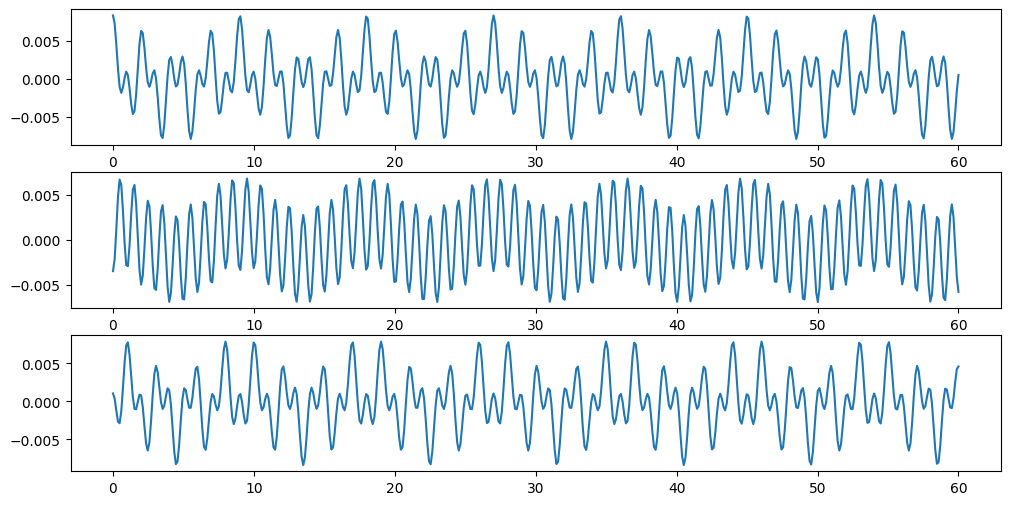

In [4]:
f0 = 1
init_disp = 100e-3
v0 = 0.0
vv0 = torch.zeros(nx)

t = torch.linspace(0,60,nt)

# init_load = {
#     "type" : "point_load",
#     "f0" : f0,
#     "load_coord" : 0.1,
# }
# w0 = ss_beam.init_cond_load(init_load)
# wxt, wxt_n = ss_beam.free_vibration(t, w0, vv0, 0.0)

# forcing = {
#     "type" : "step_load",
#     "force_mag" : f0,
#     "load_coord" : 0.1
# }
# forcing = {
#     "type" : "harmonic",
#     "force_mag" : f0,
#     "load_coord" : 0.1,
#     "frequency" : 0.8
# }
# wxt, wxt_n = ss_beam.forced_vibration(t, forcing)

init_disp_loc = 0.1
init_disp_id = torch.argmin(torch.abs(ss_beam.xx - init_disp_loc))
w0 = torch.zeros(nx)
w0[init_disp_id] = init_disp
wxt, wxt_n = ss_beam.free_vibration(t, w0, vv0, 0.01)

s_locs = [0.25, 0.5, 0.75]
s_ids = [np.argmin(np.abs(xx - s_locs[i])) for i in range(3)]
fig, axs = plt.subplots(3, 1, figsize = (12,6))
for i in range(3):
    axs[i].plot(t, wxt[s_ids[i],:])
    # axs[i].plot(t, wxt_n[s_ids[0],:,i],linestyle='--')

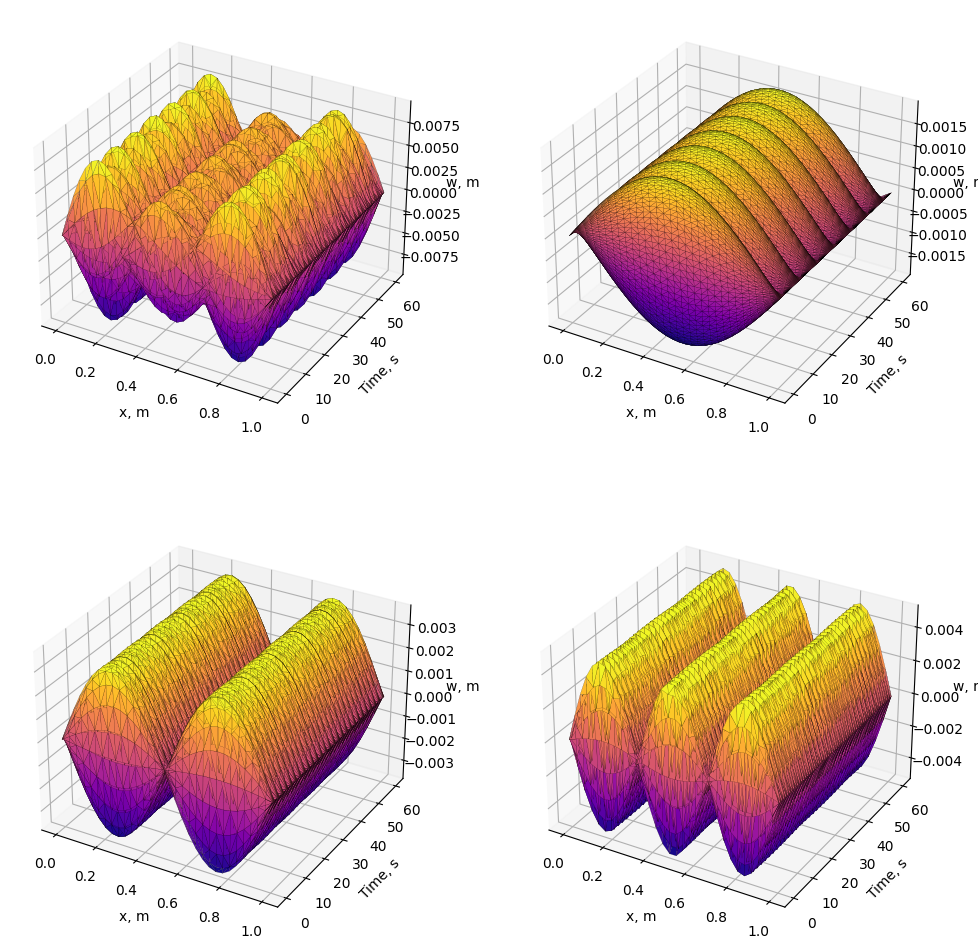

In [5]:
fig, axs = plt.subplots(2, 2, subplot_kw = {"projection":"3d"}, figsize=(12,12))
axs = axs.ravel()
plot_vib_surface(axs[0], xx, t, wxt, 1)
plot_vib_surface(axs[1], xx, t, wxt_n[:,:,0], 1)
plot_vib_surface(axs[2], xx, t, wxt_n[:,:,1], 1)
plot_vib_surface(axs[3], xx, t, wxt_n[:,:,2], 1)

Normalise

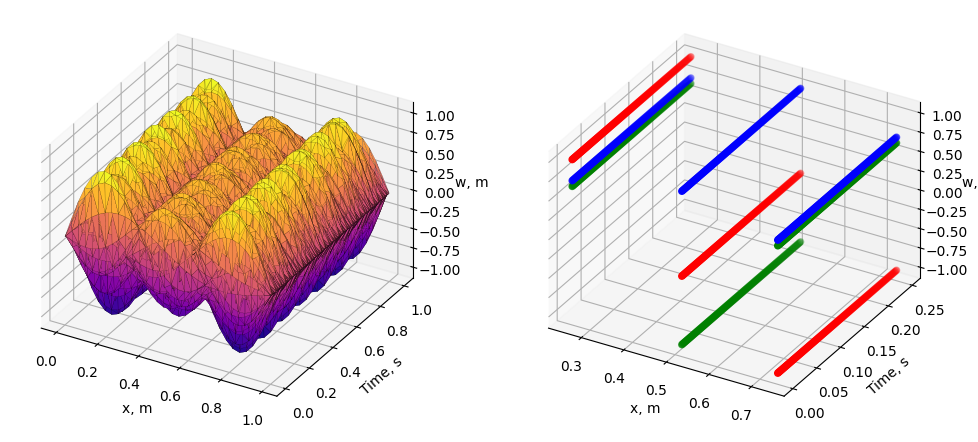

In [32]:
t_hat, alpha_t = normalise(t, "range")
x_hat, alpha_x = normalise(xx, "range")
w_hat, alpha_w = normalise(wxt, "range", "all")
wn_hat = wxt_n / alpha_w

alphas = {
    "x" : alpha_x,
    "t" : alpha_t,
    "w" : alpha_w
}

# sub_ind_x = np.arange(0, int(nx/4), 1)
sub_ind_x = torch.tensor(s_ids)
sub_ind_t = np.arange(0, int(nt/4), 1)

x_data_vec = x_hat[sub_ind_x]
t_data_vec = t_hat[sub_ind_t]
phi_data_vec = ss_beam.phi_n[sub_ind_x, :]

w_data_mat = w_hat[:, sub_ind_t][sub_ind_x, :]
wn_data_mat = wn_hat[:, sub_ind_t, :][sub_ind_x, :, :]

sens_ids_ = [torch.argmin(torch.abs(x_data_vec - s_locs[i])) for i in range(3)]
# s_ids = [np.argmin(np.abs(xx - s_locs[i])) for i in range(3)]

x_data, t_data, w_data, phi_data = gen_NN_data(x_data_vec, t_data_vec, w_data_mat, phi_data_vec)
x_pred, t_pred, w_pred, phi_pred = gen_NN_data(x_hat, t_hat, w_hat, ss_beam.phi_n)

fig, axs = plt.subplots(1, 2, subplot_kw = {"projection":"3d", "proj_type":"ortho"}, figsize=(12,12))
plot_vib_surface(axs[0], x_hat, t_hat, w_hat, 1)
# axs[0].view_init(elev=0, azim=-90)

# plot_vib_surface(axs[1], x_data_vec, t_data_vec, w_data_mat, 1)
# plot_vib_scatter(axs[1], x_data, t_data, w_data)
colors = ['b', 'r', 'g']
for n in range(n_modes):
    plot_vib_scatter(axs[1], x_data, t_data, phi_data[:,n], color=colors[n])
# axs[1].view_init(elev=0, azim=-90)

## 'Black-box' single-network architecture

$$
\mathrm{argmin}\mathcal{L}(\mathbf{x},t;\mathbf{\theta}) := \langle  \hat{w}^* - \mathcal{N}_{\hat{w}} \rangle
$$

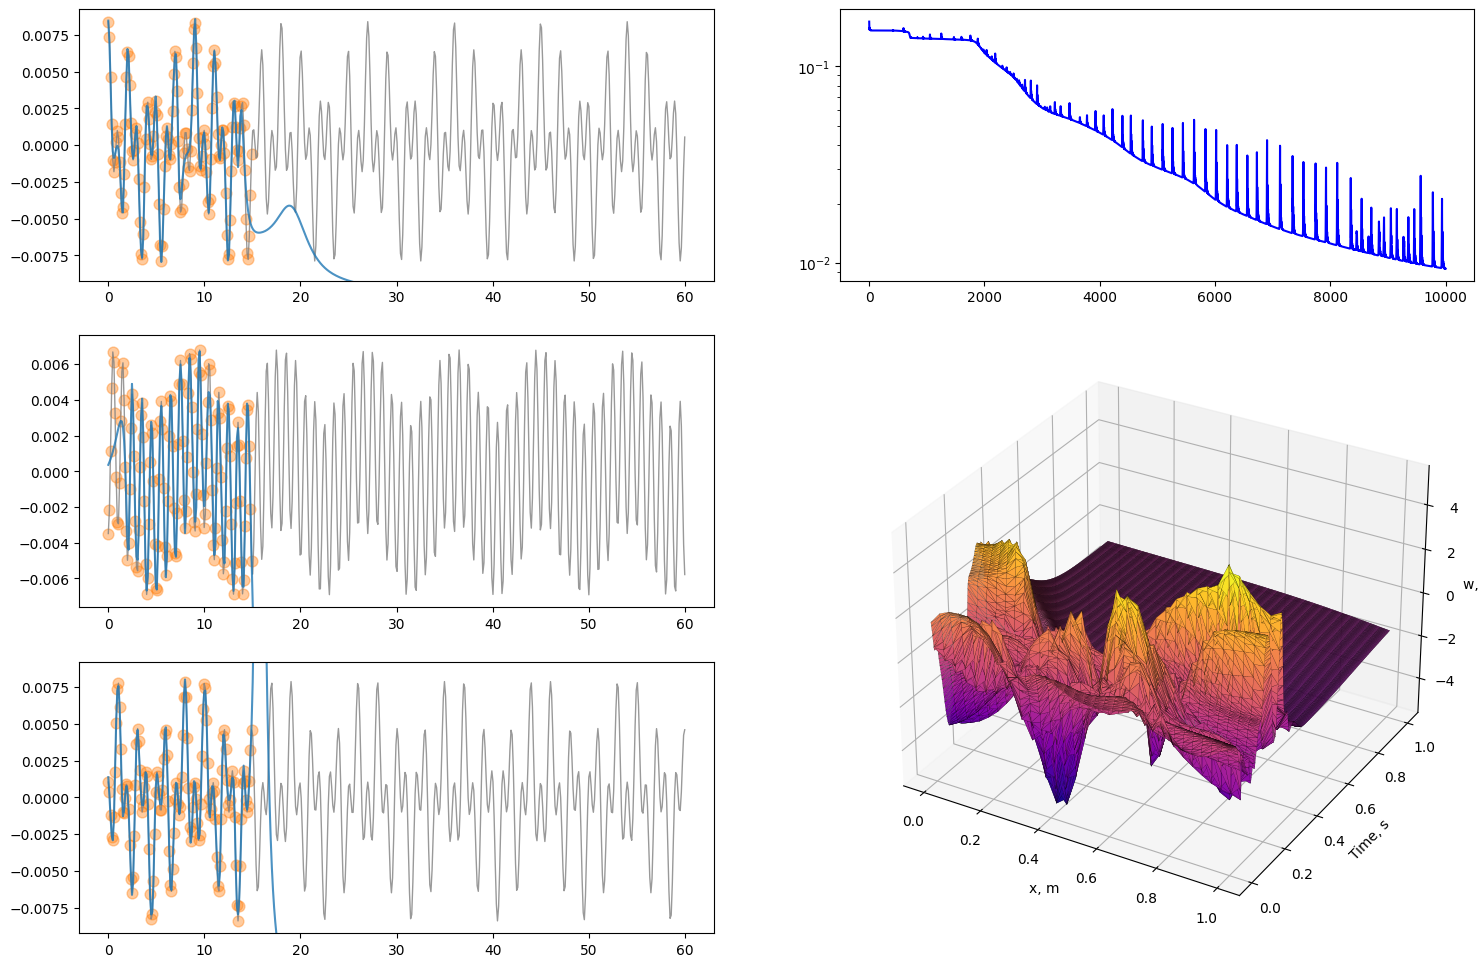

In [7]:
def plot_result_sens(axs_m, t_hat, w_hat, t_data, w_data, wpred, alphas):
    axs = [axs_m["A"], axs_m["B"], axs_m["C"]]
    for ax in axs:
        ax.cla()
    xL = torch.amax(t_hat)*alphas["t"]
    for i in range(3):
        axs[i].plot(t_hat * alphas["t"], w_hat[s_ids[i],:] * alphas["w"], color="grey", linewidth=1, alpha=0.8, label="Exact solution")
        axs[i].plot(t_hat * alphas["t"], wpred[s_ids[i],:] * alphas["w"], color="tab:blue", linewidth=1.5, alpha=0.8, label="Neural network prediction")
        axs[i].scatter(t_data * alphas["t"], w_data[sens_ids_[i],:] * alphas["w"], s=60, color="tab:orange", alpha=0.4, label='Training data')
        yL = torch.amax(torch.abs(w_hat[s_ids[i],:]))*alphas["w"]
        axs[i].set_xlim(-0.05*xL, 1.05*xL)
        axs[i].set_ylim(-1.1*yL, 1.1*yL)
    # l = ax.legend(loc=(1.01,0.34), frameon=False, fontsize="large")

def plot_nn_update(axs_m, t_hat, w_hat, t_data, w_data, xpred, tpred, wpred, alphas):
    axs = [axs_m["A"], axs_m["B"], axs_m["C"]]
    for ax in axs:
        ax.cla()
    xL = torch.amax(t_hat)*alphas["t"]
    for i in range(3):
        axs[i].plot(t_hat * alphas["t"], w_hat[s_ids[i],:] * alphas["w"], color="grey", linewidth=1, alpha=0.8, label="Exact solution")
        axs[i].plot(tpred * alphas["t"], wpred[s_ids[i],:] * alphas["w"], color="tab:blue", linewidth=1.5, alpha=0.8, label="Neural network prediction")
        axs[i].scatter(t_data * alphas["t"], w_data[sens_ids_[i],:] * alphas["w"], s=60, color="tab:orange", alpha=0.4, label='Training data')
        yL = torch.amax(torch.abs(w_hat[s_ids[i],:]))*alphas["w"]
        axs[i].set_xlim(-0.05*xL, 1.05*xL)
        axs[i].set_ylim(-1.1*yL, 1.1*yL)
    axs_m['E'].cla()
    plot_vib_surface(axs_m['E'], xpred, tpred, wpred, 1)
    # l = ax.legend(loc=(1.01,0.34), frameon=False, fontsize="large")

def plot_loss_hist(ax,loss_hist):
    # plt.figure(figsize=(6,6))
    ax.cla()
    n_epoch = len(loss_hist)
    ax.plot(np.arange(1,n_epoch+1),loss_hist,'b')
    ax.set_yscale('log')
    
# train standard neural network to fit training data
torch.manual_seed(43810)
epochs = int(10e3)
bb_model = bbnn(2,1,32,3)
optimizer = torch.optim.Adam(bb_model.parameters(),lr=5e-3)
# optimizer = torch.optim.SGD(bb_model.parameters(),lr=1e-3, momentum=0.5)
print_step = 50
loss_hist = []

# fig, axs = plt.subplots(1,2,figsize=(18,6),facecolor='w')
# fig, axs = plt.subplot_mosaic("AD;BD;CD", figsize=(18,12), facecolor='w')
fig, axs = plt.subplot_mosaic(
    "AD;BE;CE",
    per_subplot_kw = {
    "E" : {"projection" : "3d"}
    },
    figsize=(18,12), 
    facecolor='w'
    )
for i in tqdm(range(epochs)):
    optimizer.zero_grad()
    loss = bb_model.loss_func(x_data, t_data, w_data)
    loss_hist.append(loss.item())
    loss.backward()
    optimizer.step()
    
    # plot the result as training progresses
    if (i+1) % print_step == 0: 
        
        wpred_vec = bb_model.predict(x_pred, t_pred).detach()
        wpred = roll_mat(wpred_vec, nx, nt)
        
        plot_nn_update(axs, t_hat, w_hat, t_data_vec, w_data_mat, x_hat, t_hat, wpred, alphas)
    
        plot_loss_hist(axs["D"],loss_hist)
        display.clear_output(wait=True)
        display.display(plt.gcf())

display.clear_output()


In [ ]:
# save network weights to improve performance of PINN

torch.save(bb_model.state_dict(), 'bb_model_trained.pt')

## 'Black-box' multi-network parallel architecture

$$
\mathrm{argmin}\mathcal{L}(\mathbf{x},t;\mathbf{\theta}) := \langle  \hat{w}^* - \hat{w}_{est} \rangle
$$
$$
\hat{w}_{est} = \sum_{j=1}^n \varphi_j \mathcal{N}_{\hat{q}}^{(j)}
$$
where $n$ is the number of modes, $\varphi_j$ is the shape of mode $j$, and $\mathcal{N}^{(j)}$ is the output of neural network $j$.

  1%|          | 1249/100000 [00:43<57:31, 28.61it/s]  


KeyboardInterrupt: 

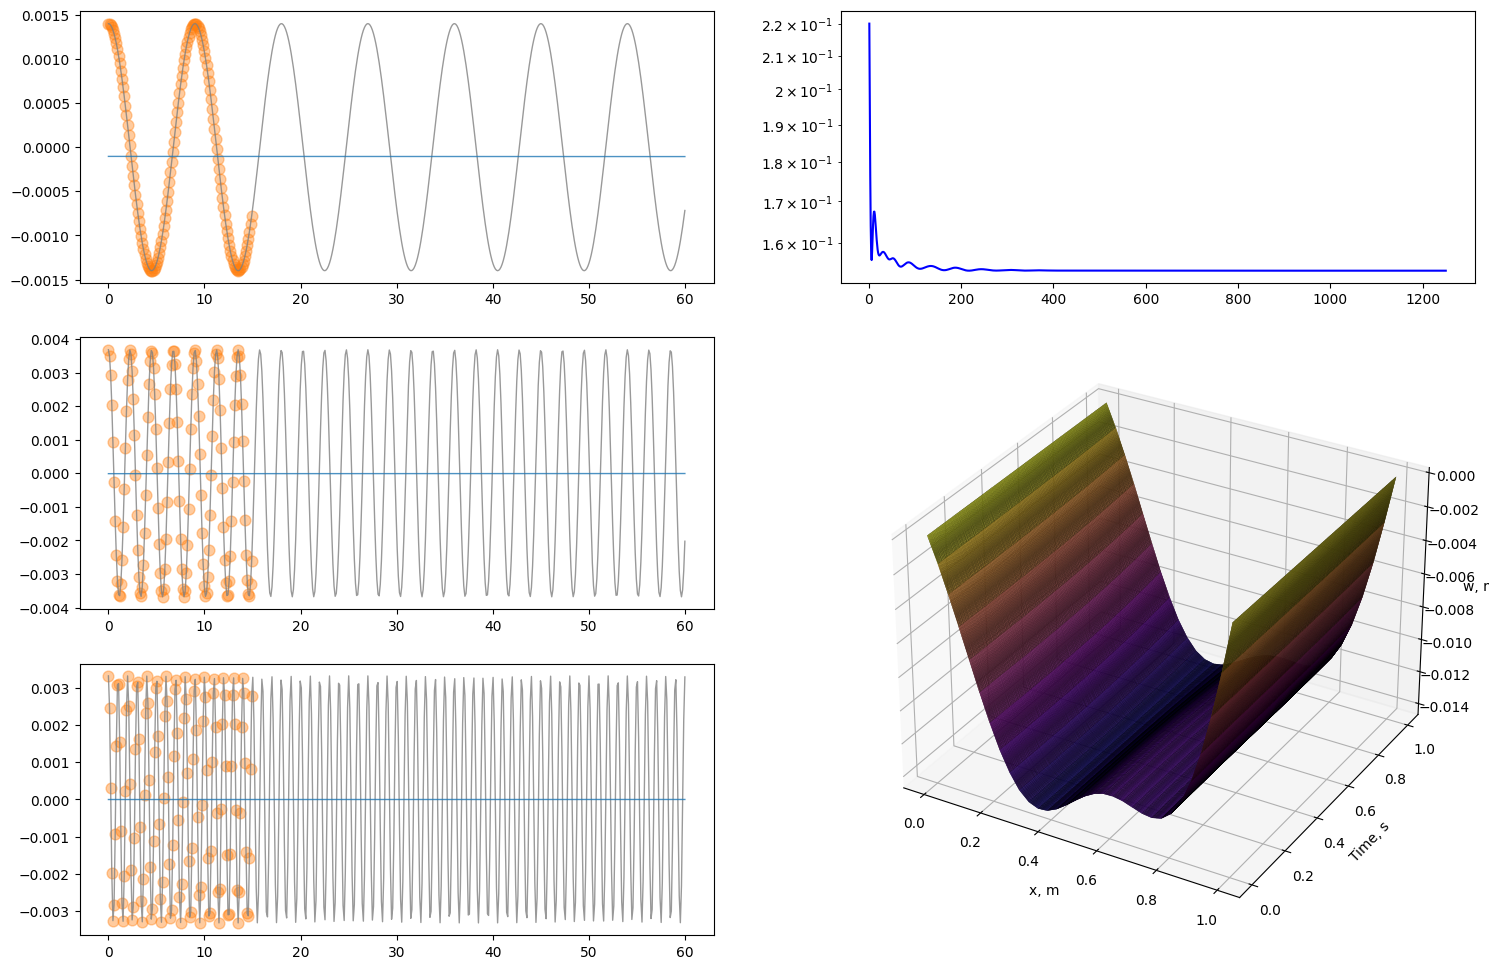

In [23]:
def plot_modal_pred(axs_m, t_hat, wn_hat, t_data, wn_data, xpred, tpred, wn_pred, alphas):
    axs = [axs_m["A"], axs_m["B"], axs_m["C"]]
    for ax in axs:
        ax.cla()
    xL = torch.amax(t_hat)*alphas["t"]
    for i in range(3):
        axs[i].plot(t_hat * alphas["t"], wn_hat[s_ids[0],:,i] * alphas["w"], color="grey", linewidth=1, alpha=0.8, label="Exact solution")
        axs[i].plot(t_hat * alphas["t"], wn_pred[s_ids[0],:,i] * alphas["w"], color="tab:blue", linewidth=1, alpha=0.8, label="Neural network prediction")
        axs[i].scatter(t_data * alphas["t"], wn_data[0,:,i] * alphas["w"], s=60, color="tab:orange", alpha=0.4, label='Training data')
        yL = torch.amax(torch.abs(wn_hat[s_ids[0],:,i]))*alphas["w"]
        axs[i].set_xlim(-0.05*xL, 1.05*xL)
        axs[i].set_ylim(-1.1*yL, 1.1*yL)
    axs_m['E'].cla()
    plot_vib_surface(axs_m['E'], xpred, tpred, torch.sum(wn_pred, dim=2), 1)

# train standard neural network to fit training data
torch.manual_seed(43810)
epochs = int(100e3)
learning_rate = 1e-3
betas = (0.99, 0.999)

N = n_modes  # number of modes to model
bb_par_model = beam_bb_par(
    N_INPUT = 2,
    N_OUTPUT = 1,
    N_HIDDEN = 32,
    N_LAYERS = 4,
    N_MODES = N
)

print_step = 50
loss_hist = []
wn_pred = torch.zeros((nx, nt, N))

optimizer = torch.optim.Adam(bb_par_model.parameters(), lr=learning_rate, betas=betas)

fig, axs = plt.subplot_mosaic(
    "AD;BE;CE",
    per_subplot_kw = {
    "E" : {"projection" : "3d"}
    },
    figsize=(18,12), 
    facecolor='w'
    )

for i in tqdm(range(epochs)):

    optimizer.zero_grad()
    loss = bb_par_model.loss_func(x_data, t_data, w_data, phi_data)
    loss_hist.append(loss.item())
    loss.backward()
    optimizer.step()
    
    # plot the result as training progresses
    if (i+1) % print_step == 0: 
        
        wn_pred_vec = bb_par_model.predict(x_pred, t_pred, phi_pred).detach()
        for n in range(N):
            wn_pred[:,:,n] = roll_mat(wn_pred_vec[:,n], nx, nt)
        
        plot_modal_pred(axs, t_hat, wn_hat, t_data_vec, wn_data_mat, x_hat, t_hat, wn_pred, alphas)
    
        plot_loss_hist(axs["D"],loss_hist)
        display.clear_output(wait=True)
        display.display(plt.gcf())

display.clear_output()

## 'Black-box' multi-network sequential architecture

$$
\mathrm{argmin}\mathcal{L}_j(\mathbf{x},t;\mathbf{\theta}_j) := \langle  \hat{w}^* - \varphi_j \mathcal{N}_{\hat{q}}^{(j)} \rangle
$$

In [ ]:
def plot_modal_pred(axs_m, t_hat, wn_hat, t_data, wn_data, wn_pred, alphas):
    axs = [axs_m["A"], axs_m["B"], axs_m["C"]]
    for ax in axs:
        ax.cla()
    xL = torch.amax(t_hat)*alphas["t"]
    for i in range(3):
        axs[i].plot(t_hat * alphas["t"], wn_hat[s_ids[0],:,i] * alphas["w"], color="grey", linewidth=1, alpha=0.8, label="Exact solution")
        axs[i].plot(t_hat * alphas["t"], wn_pred[s_ids[0],:,i] * alphas["w"], color="tab:blue", linewidth=1, alpha=0.8, label="Neural network prediction")
        axs[i].scatter(t_data * alphas["t"], wn_data[0,:,i] * alphas["w"], s=60, color="tab:orange", alpha=0.4, label='Training data')
        yL = torch.amax(torch.abs(wn_hat[s_ids[0],:,i]))*alphas["w"]
        axs[i].set_xlim(-0.05*xL, 1.05*xL)
        axs[i].set_ylim(-1.1*yL, 1.1*yL)

# train standard neural network to fit training data
torch.manual_seed(43810)
epochs = int(100e3)
learning_rate = 1e-3
betas = (0.99, 0.999)

N = 3  # number of modes to model
bb_seq_model = beam_bb_seq(
    N_INPUT = 2,
    N_OUTPUT = 1,
    N_HIDDEN = 32,
    N_LAYERS = 2,
    N_MODES = N
)

print_step = 50
loss_hist = []
wn_pred = torch.zeros((nx, nt, N))

fig, axs = plt.subplot_mosaic(
    "AD;BE;CE",
    per_subplot_kw = {
    "E" : {"projection" : "3d"}
    },
    figsize=(18,12), 
    facecolor='w'
    )

for n in tqdm(range(N), desc="outer", position=0):

    optimizer = torch.optim.Adam(bb_seq_model.seq_NNs[n].parameters(), lr=learning_rate, betas=betas)

    for i in tqdm(range(epochs), desc="inner", position=1, leave=False):

        optimizer.zero_grad()
        loss = bb_seq_model.ind_loss_func(x_data, t_data, w_data, phi_data, n)
        loss_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        
        # plot the result as training progresses
        if (i+1) % print_step == 0: 
            
            wn_pred_vec = bb_seq_model.predict(x_pred, t_pred, phi_pred).detach()
            for n in range(N):
                wn_pred[:,:,n] = roll_mat(wn_pred_vec[:,n], nx, nt)
            
            plot_modal_pred(axs, t_hat, wn_hat, t_data_vec, wn_data_mat, wn_pred, alphas)
        
            plot_loss_hist(axs["D"],loss_hist)
            display.clear_output(wait=True)
            display.display(plt.gcf())

    display.clear_output()